In [ ]:
# default_exp funcs.merfish_viz

In [ ]:
%load_ext autoreload
%autoreload 2

# MERFISH visualization

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import matching

import io, requests
from sklearn.neighbors import NearestNeighbors
from starfish import data
import pprint

In [ ]:
from decode_fish.funcs.merfish_eval import *
bench_df, code_ref, targets = get_benchmark()

13832


In [ ]:
pred_df = pd.read_csv('../data/results/MERFISH/exp_c3d_02noise.csv')
pred_df = exclude_borders(pred_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
pred_df.loc[pred_df['frame_idx']>7] = shift_df(pred_df[pred_df['frame_idx']>7], [5,20,0])
pred_df.loc[:,'comb_sig'] = 100*(pred_df.loc[:,'comb_sig']-1)
len(pred_df)

303099

In [ ]:
from decode_fish.funcs.evaluation import *
perfs = DF()

shift_x = np.zeros([16,16])
shift_y = np.zeros([16,16])
rmse_vol = np.zeros([16,16])

for i in tqdm(range(0,15)):
    for j in range(i+1,16):
        df1 = pred_df[pred_df['frame_idx']==i].copy()
        df2 = pred_df[pred_df['frame_idx']==j].copy()
        df1.loc[:,'frame_idx'] = 0
        df2.loc[:,'frame_idx'] = 0

        perf, matches, shift = matching(df1[:], df2[:], print_res=False, tolerance=200)
#         display(DF.from_records([perf]))
        shift_x[i,j] = shift[0]
        shift_y[i,j] = shift[1]
        rmse_vol[i,j] = perf['rmse_vol']
#         print(shift)

100%|████████████████████████████████████████████████████████████| 15/15 [12:12<00:00, 48.86s/it]


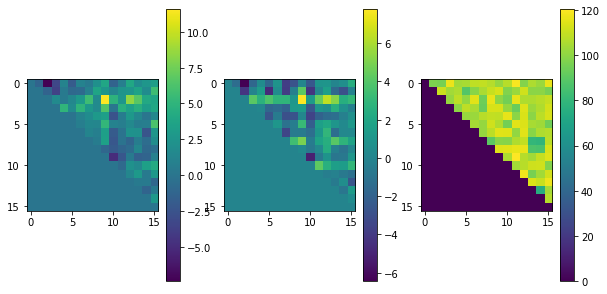

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow((shift_y))
plt.colorbar()
plt.subplot(132)
plt.imshow((shift_x))
plt.colorbar()
plt.subplot(133)
plt.imshow((rmse_vol))
plt.colorbar()

In [ ]:
# from decode_fish.funcs.merfish_eval import *
res_df = code_from_xy_logs(pred_df, code_ref, targets, group_rad=150, prob_smoothing=1)

100%|██████████████████████████████████████████████████| 303099/303099 [01:12<00:00, 4197.73it/s]


ValueError: Wrong number of items passed 16, placement implies 1

In [ ]:
#export
def make_roc(df, var='code_err', ascending=True):
    
    x = np.arange(1000,len(df),100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['gene'].str.contains('Blank')).sum())
        
    return x, n_blanks

In [ ]:
roc_dict = {'res_df':[res_df, 'code_err', True],
            'bench_df':[bench_df, 'total_magnitude', False]}

(0.0, 20000.0)

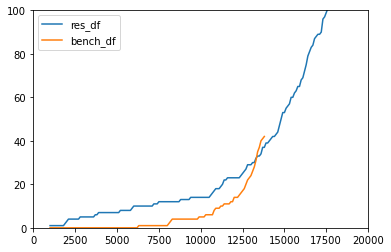

In [ ]:
for k in roc_dict:
    x, y = make_roc(*roc_dict[k])
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 20000)

In [ ]:
res_sub = res_df[:5000]

In [ ]:
matches, bench_match = match_bench(res_sub, bench_df)

[82.2452902881192, 82.18823525412772, -43.147103387827784]
Recall: 0.241
Precision: 0.668
Jaccard: 21.560
RMSE_vol: 100.456
Eff_3d: 6.856
FN: 10492.0 FP: 1660.0
Num. matches: 3340.000
Shift: 1.91,1.32,0.08


In [ ]:
sum(matches['gene_pred'] == matches['gene_tar'])/len(matches)

0.8697604790419161

In [ ]:
bench_counts = DF(data=None, index=targets)
bench_counts['Res_all'] = res_sub.groupby('gene')['gene'].count()
bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
bench_counts = bench_counts.fillna(0)

fps = res_sub.loc[~res_sub['loc_idx'].isin(matches['pred_idx'])]
fns = bench_match.loc[~bench_match['loc_idx'].isin(matches['tar_idx'])]

bench_counts['Res_fp'] = fps.groupby('gene')['gene'].count()
bench_counts['Res_fns'] = fns.groupby('gene')['gene'].count()
bench_counts=bench_counts.fillna(0)

In [ ]:
#export
def plot_gene_numbers(bench_counts, res_counts, title='', log=True, corr=True):
    
    if corr:
        r = np.corrcoef(bench_counts, res_counts)[0, 1]   
        r = np.round(r, decimals=3)
    else:
        r = np.sum(res_counts)
    x_lim = np.max([bench_counts.max(), res_counts.max()])
    x = np.linspace(0, x_lim)
    
    plt.scatter(bench_counts, res_counts, 50, zorder=2)
    plt.plot(x, x, '-k', zorder=1)

    plt.xlabel('Gene copy number Benchmark')
    plt.ylabel('Gene copy number DECODE')
    if log:
        plt.xscale('log')
        plt.yscale('log')
    plt.title(f'{title} r = {r}');

13832 17000


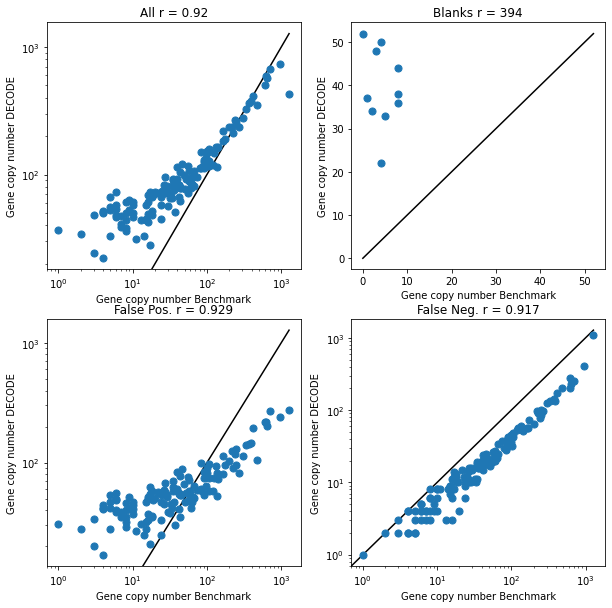

In [ ]:
print(len(bench_df), len(res_sub))

plt.figure(figsize=(10,10))
plt.subplot(221)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_all'].values, 'All', log=True)

binds = []
for i,g in enumerate(targets):
    if 'Blank' in g:
        binds.append(g)
        
plt.subplot(222)
plot_gene_numbers(bench_counts.loc[binds, 'Bench_all'].values, bench_counts.loc[binds,'Res_all'].values, 'Blanks', log=False, corr=False)

plt.subplot(223)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fp'].values, 'False Pos.', log=True)

plt.subplot(224)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fns'].values, 'False Neg.', log=True)

In [ ]:
image_paths = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/*.tiff'))

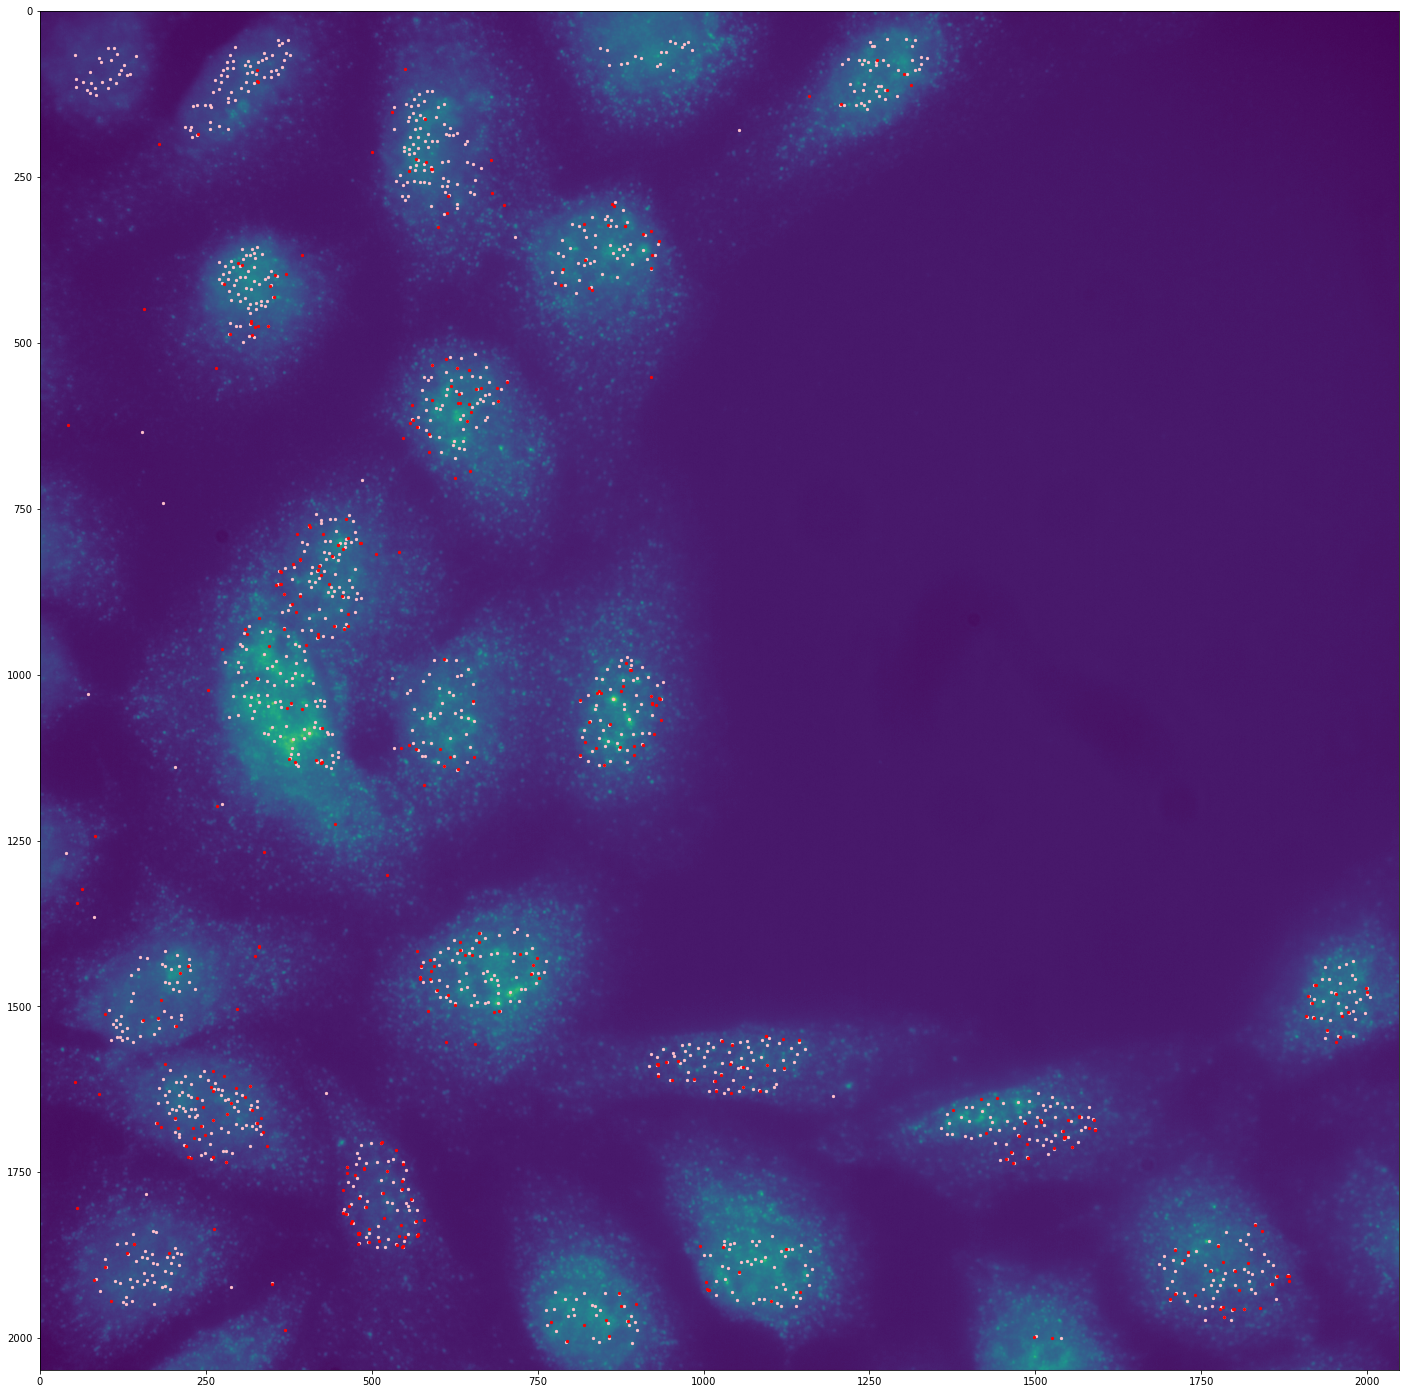

In [ ]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_sub)[res_sub['gene']=='MALAT1']
bench_px = nm_to_px(bench_match)[bench_match['gene']=='MALAT1']
plt.figure(figsize=(25,25))
plt.imshow(img[0,0])

plt.scatter(bench_px['x'],bench_px['y'], color='pink', s=5)
plt.scatter(preds_px['x'],preds_px['y'], color='red', s=5)

In [ ]:
img_stack = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff')[:,0]

In [ ]:
def extract_roi(beads: torch.Tensor, coordinates: torch.Tensor, size_xy: int=10, size_z: int=10):
    res = []
    tot_size = torch.Size([1, 16, size_xy*2+1, size_xy*2+1])
    
    x, y, z = coordinates
    crop = np.s_[:,:, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

In [ ]:
# ADD THE ACTUAL LOG NUMBERS AND PLOT THEM ON TOP OF THE IMAGES> SOME ASSIGNEMENTS LOOK WEIRD AS FUCK

76


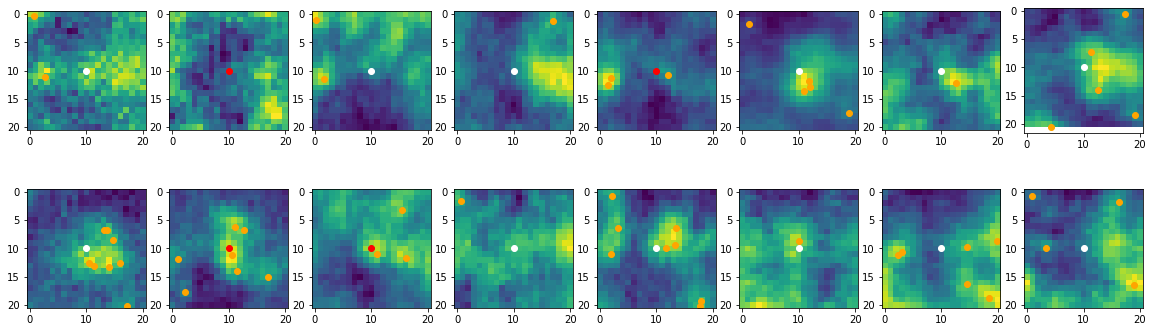

In [ ]:
# Random predictions 
sub = res_sub
# Random blank 
sub = res_sub[res_sub['gene'].str.contains('Blank')]

ind = np.random.randint(0, len(sub))
print(ind)

b_loc = nm_to_px(sub.iloc[ind])
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 10, 8)

crop = crop_df(nm_to_px(pred_df), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    color = 'red' if code_ref[list(targets.values).index(b_loc['gene'])][i] else 'white'
    plt.scatter([10],[10], color=color)
    
    cdf = crop[crop['frame_idx']==i]
    plt.scatter(cdf['x'],cdf['y'],color='orange')

,Unnamed: 0,barcode,barcode_id,fov_id,total_magnitude,area,is_exact,error_bit,error_dir,av_distance,x,y,wx,wy,gene,frame_idx,loc_idx,int,z
18644,18644,0000000101011000,59,0,98.357117,7,1,0,0,0.412399,568.020689,350.036609,568.685303,351.254517,TLN1,0,6137,98.357117,0.933457


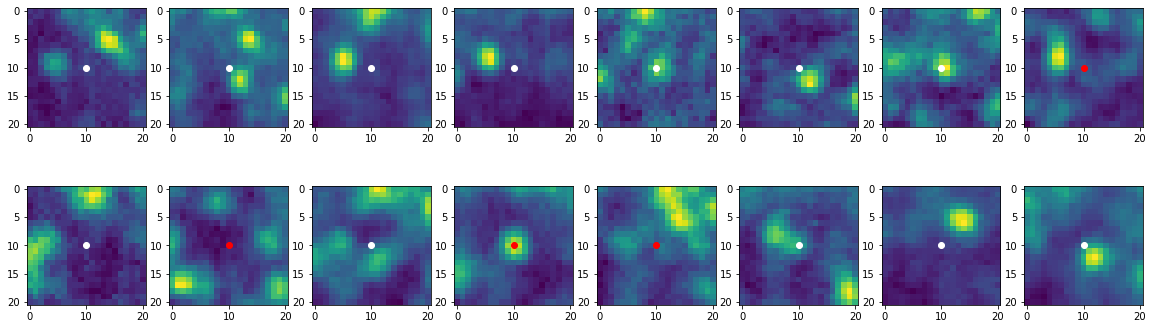

In [ ]:
ind = np.random.randint(0, len(bench_match))
# ind = 17048
b_loc = nm_to_px(bench_match.iloc[ind])
display(DF(b_loc).T)
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 10, 8)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    color = 'red' if int(b_loc['barcode'][i] )else 'white'
    plt.scatter([10],[10], color=color)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted hyper.ipynb.
Converted index.ipynb.


In [ ]:
code_ref[list(targets.values).index('TLN1')]

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=uint8)